In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tdescore.combine.parse import load_metadata
from tdescore.raw.tde import is_tde
import numpy as np
from tdescore.classifier.features import relevant_columns
from tdescore.classifier.collate import get_all_sources, get_classified_sources

In [2]:
counts = {}

In [3]:
full_data = get_all_sources()
counts["start"] = len(full_data)
full_data["has_classification"] = ~(pd.isnull(full_data["crossmatch_bts_class"]) & pd.isnull(full_data["fritz_class"]) & ~is_tde(full_data["ztf_name"]))
full_data["has_classification"].replace(False, None, inplace=True)

In [4]:
def generate_null_mask(df, fields):
    mask = np.ones(len(df), dtype=bool)
    
    for field in fields:
        mask *= ~pd.isnull(df[field])
        
    return ~mask

In [5]:
steps = [
    ("Has Classification?", ["has_classification"]),
#     ("Has Rise?", ["rise"]),
    ("Has Fade and Colour Change?", ["fade", "color_grad", "peak_color"]),
    ("Has Lightcurve Parameters?", ["pre_inflection", "post_inflection", "length_scale", "classtar", "y_scale", "sumrat", "positive_fraction", "det_cadence", "score", "distnr"]),
    ("Has WISE-detected host?", ["w1_m_w2", "w3_m_w4", "w1_chi2"]),
    ("Has PS1-detected host?",  ["g-r_MeanPSFMag", "r-i_MeanPSFMag", "i-z_MeanPSFMag", "z-y_MeanPSFMag", "distpsnr1", "sgscore1"]),
    ("Has SNCosmo parameters?", ["sncosmo_chisq", "sncosmo_chi2pdof", "sncosmo_x1", "sncosmo_c"]),
]

In [6]:
full_data["class"] = is_tde(full_data["ztf_name"])

df = full_data
# df = df[full_data["class"]]

used_fields = []

res = [{"label": "ZTF Nuclear Sample", "match": len(df), "miss": 0}]

for label, fields in steps:
    class_mask = generate_null_mask(df, fields)
    print(label, np.sum(~class_mask), np.sum(class_mask))
    df = df[~class_mask]
    res.append({"label": label, "match": np.sum(~class_mask), "miss": np.sum(class_mask)})
    
    for field in fields:
        used_fields.append(field)
    
res.append({"label": "Final Nuclear ML Sample", "match": len(df), "miss": 0})
    
res = pd.DataFrame(res)
res

# counts["classfied"] = (np.sum(~class_mask), np.sum(class_mask))

Has Classification? 5819 5880
Has Fade and Colour Change? 3398 2421
Has Lightcurve Parameters? 3398 0
Has WISE-detected host? 3074 324
Has PS1-detected host? 3036 38
Has SNCosmo parameters? 3027 9


,label,match,miss
0,ZTF Nuclear Sample,11699,0
1,Has Classification?,5819,5880
2,Has Fade and Colour Change?,3398,2421
3,Has Lightcurve Parameters?,3398,0
4,Has WISE-detected host?,3074,324
5,Has PS1-detected host?,3036,38
6,Has SNCosmo parameters?,3027,9
7,Final Nuclear ML Sample,3027,0


In [7]:
left_fields = [x for x in relevant_columns if x not in used_fields]
left_fields
# Every source has a value for 'has_milliquas' (it's a boolean)

['has_milliquas']

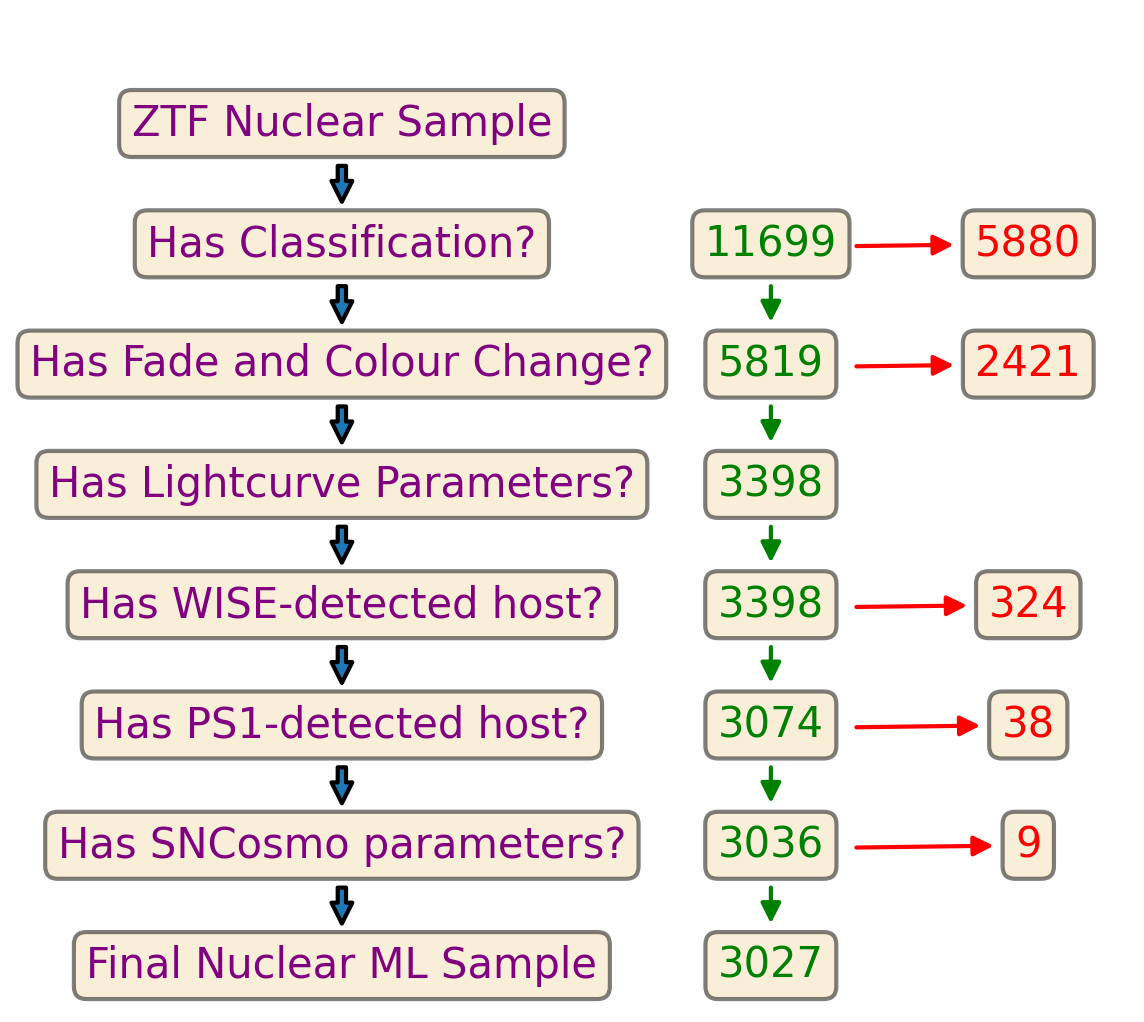

In [8]:
plt.figure(figsize=(4.0, 2.0 + 0.3 * len(steps)), dpi=300.0)
plt.subplot(111)

n_tot = len(steps) + 2

y_scale = 1.0 / float(n_tot)

base_offset = 0.8
x_offset_name = 0.1
x_offset_description = 0.6
x_offset_reject = 0.9

for i, row in res.iterrows():
    y_0 = 1.0 - y_scale * (i + base_offset + 0.7)
    y_1 = 1.0 - y_scale * (i + base_offset)

    xy_name = (x_offset_name, y_0)
    xytext = (x_offset_name, y_1-0.01)
    xy_description = (x_offset_description, y_0 - y_scale)
    xytext_description = (x_offset_description, y_1 - y_scale -0.01)
    xy_reject = (x_offset_description+0.09, y_1)
    xytext_reject = (x_offset_reject, y_1 -0.01)

    arrowprops = {
        "arrowstyle": "simple",
    } if i < n_tot - 1 else None

    annotate_args = {
        "xycoords": "axes fraction",
        "ha": "center",
        "arrowprops": arrowprops,
        "bbox": {
            "boxstyle": "round",
            "facecolor": "wheat",
            "alpha": 0.5,
        },
    }
    
    
    annotate_args_accept = {
        "xycoords": "axes fraction",
        "ha": "center",
        "arrowprops": {"arrowstyle": '-|>', "color": "green"} if i < n_tot - 2 else None,
        "bbox": {
            "boxstyle": "round",
            "facecolor": "wheat",
            "alpha": 0.5,
        },
    }
    annotate_args_reject = {
        "xycoords": "axes fraction",
        "ha": "center",
        "arrowprops": {"arrowstyle": '<|-', "color": "r"},
        "bbox": {
            "boxstyle": "round",
            "facecolor": "wheat",
            "alpha": 0.5,
        },
    }

    plt.annotate(
        text=row["label"],
        xy=xy_name,
        xytext=xytext,
        color="purple",
        **annotate_args,
    )
    
    if i < n_tot - 1:

        plt.annotate(
            text=row["match"],
            xy=xy_description,
            xytext=xytext_description,
            color="green",
            **annotate_args_accept,
    #         **annotate_args,
        )
    
    if row["miss"] > 0:
    
        plt.annotate(
            text=row["miss"],
            xy=xy_reject,
            xytext=xytext_reject,
            color="red",
            **annotate_args_reject,
        )


plt.tight_layout()
plt.axis("off")
plt.savefig("figures/flowchart.png", bbox_inches='tight')

57


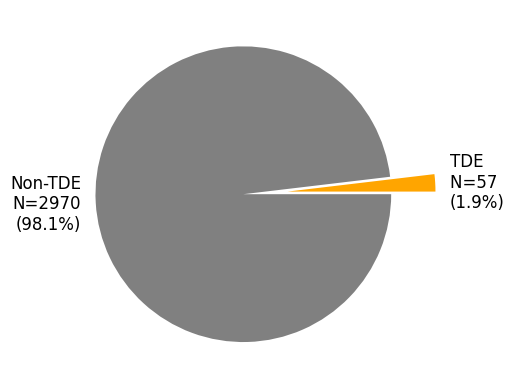

In [9]:
df["class"] = is_tde(df["ztf_name"])
print(np.sum(df["class"]))

data = [np.sum(df["class"]), np.sum(~df["class"])]
plt.pie(
    data,
    labels=[f"TDE \nN={data[0]} \n({100.*data[0]/np.sum(data):.1f}%)", f"Non-TDE\nN={data[1]}\n({100.*data[1]/np.sum(data):.1f}%)"],
    colors=["orange", "grey", ],
#     autopct='%1.1f%%',
    explode=[0.3, 0.0],
    pctdistance=0.8,
    textprops={'size': 'larger'}
    
)
plt.savefig("figures/pie.png", bbox_inches='tight')